In [1]:
from copy import deepcopy
from itertools import combinations
import typing as tp

import numpy as np
import pandas as pd
from numpy.linalg import lstsq
from scipy.optimize import linprog

from matplotlib import pyplot as plt
from citk.layer import Dense, FuzzyGMDHLayer
from citk.model import FFN, GMDH
from citk.functions import ReLU, Linear, BellMembership, GaussianMembership, Poly
from citk.losses import MSE, FMSE
from citk.optimisers import SGDOptimizer, SimplexOptimizer

from utils import seed_everything, normalize_df, create_lags

%matplotlib inline

In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /

# Data

In [2]:
RANDOM_SEED = 42
N_LAGS = 2
INITIAL_TEST_LEN = 8

seed_everything(RANDOM_SEED)

data = pd.read_csv('../data/data.csv', encoding='cp1251', sep=';', decimal=',').dropna()

train_df, test_df = data.iloc[:-INITIAL_TEST_LEN], data.iloc[-INITIAL_TEST_LEN:]

train_df, test_df = create_lags(
    train_df, test_df, 
    train_df.columns.tolist(), 
    N_LAGS
)

y_col = 'ІСЦ (+1)'
X_col = train_df.columns.tolist()
X_col.remove(y_col)

train_df, test_df = normalize_df(train_df, test_df, X_col)

X_train = train_df[X_col].values
X_test = test_df[X_col].values
y_train = train_df[y_col].values[..., np.newaxis]
y_test = test_df[y_col].values[..., np.newaxis]

/home/vsydorskyi/src/Neural_Net_Genetic_Alg/examples/utils.py:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[f'{col}_{sh}'] = train_df.shift(sh)[col]
/home/vsydorskyi/src/Neural_Net_Genetic_Alg/examples/utils.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[f'{col}_{sh}'] = test_df.shift(sh)[col]


# GMDH Hypersearh

## Possible architectures

If we have one GMDH layer - GMDH -> Dense

If we have two or more GMDH layers - ( GMDH -> Dense (F - outputs) ) * (N_GMDH_layers-1) -> GMDH -> Dense

In [3]:
def gmdh_pipeline_predict(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs: tp.Dict[tp.Tuple[int], np.ndarray],
                  model_weights: np.ndarray) -> np.ndarray:
    outputs = []
    for i, (k, model) in enumerate(models.items()):
        predicted = model_weights[i] * model.predict(inputs[k]).ravel()
        outputs.append(predicted)
    outputs = np.array(outputs).T
    return np.sum(outputs, axis=1)[..., np.newaxis]

def gmdh_pipeline_fit(models: tp.Dict[tp.Tuple[int], GMDH], 
                  inputs_train: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_train: np.ndarray,
                  inputs_val: tp.Dict[tp.Tuple[int], np.ndarray],
                  outputs_val: np.ndarray) -> np.ndarray:
    outputs_partial_train = []
    outputs_partial_test = []
    for k, model in models.items():
        predicted_train = model.predict(inputs_train[k]).ravel()
        outputs_partial_train.append(predicted_train)
        predicted_test = model.predict(inputs_val[k]).ravel()
        outputs_partial_test.append(predicted_test)
    outputs_partial_train = np.array(outputs_partial_train).T
    outputs_partial_test = np.array(outputs_partial_test).T
    W_vect = lstsq(outputs_partial_train, outputs_train.ravel())
    return W_vect[0]

In [4]:
do_hypersearh = True
n_gmdh_layers = 1
best_activations = 16
all_metrics = []
all_train_metrics = []
best_train_pred = None
best_test_pred = None
best_model = None
best_history = None

all_possible_pairs = list(combinations(range(X_train.shape[1]),2))[::-2][:100]
possible_models = dict()
possible_pairs_train = dict()
possible_pairs_test = dict()
best_W = None

i = 0
while do_hypersearh:
    partial_model = GMDH(
                        input_shape=len(all_possible_pairs[i]), 
                        method_type='fuzzy', 
                        poli_type='partial_quadratic',
                        loss=FMSE, 
                        confidence=0.9,
                        reg_coef=0.01
                    )
    print(f"Partial model structure: {partial_model.__dict__}")
    
    trained, history = partial_model.fit(
        train_sample=(X_train[:, all_possible_pairs[i]], y_train),
        validation_sample=(X_test[:, all_possible_pairs[i]], y_test),
        optimiser=SimplexOptimizer(alpha=0.01, eta=0.005),
        batch_size=64,
        epochs=10_000,
        verbose=False,
    )
    possible_models.update({all_possible_pairs[i]: trained})
    possible_pairs_train.update({all_possible_pairs[i]: X_train[:, all_possible_pairs[i]]})
    possible_pairs_test.update({all_possible_pairs[i]: X_test[:, all_possible_pairs[i]]})
    
    if (n_gmdh_layers == 1):
        prediction = trained.predict(X_test[:, all_possible_pairs[i]])
        test_metric = MSE(y_test, prediction)[0]
        
        train_pred = trained.predict(X_train[:, all_possible_pairs[i]])
        train_metric = MSE(y_train, train_pred)[0]
        
        all_metrics.append(test_metric)
        all_train_metrics.append(train_metric)
        W_vect = np.array([1.])
    else:
        W_vect = gmdh_pipeline_fit(possible_models, possible_pairs_train, y_train, possible_pairs_test, y_test)
        prediction = gmdh_pipeline_predict(possible_models, possible_pairs_test, W_vect)
        test_metric = MSE(y_test, prediction)[0]
        
        train_pred = gmdh_pipeline_predict(possible_models, possible_pairs_train, W_vect)
        train_metric = MSE(y_train, train_pred)[0]
        
        all_metrics.append(test_metric)
        all_train_metrics.append(train_metric)
    i += 1
    print(f"{n_gmdh_layers} layers scored {test_metric}")
    print(f"{n_gmdh_layers} layers scored train {train_metric}")
    
    if (len(all_metrics) == 1 or (all_metrics[-1] < all_metrics[-2])) and (i<len(all_possible_pairs)):
        do_hypersearh = True
        best_test_pred = prediction
        best_train_pred = train_pred
    else:
        do_hypersearh = False
        best_W = W_vect
        
    n_gmdh_layers += 1

Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x7f9e63c08690>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.9, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x7f9e63c086d0>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function FMSE at 0x7f9e65eb64d0>, 'W_vect': array([0.03857035, 0.00434684, 0.21201257, 0.0244833 , 0.06510024,
       0.12987745, 0.04012291, 0.04228585])}



1 layers scored 2.191677026578003
1 layers scored train 3.8235822692053794
Partial model structure: {'parser': <citk.layer.WeightsParser object at 0x7f9e631fbe10>, '_method_type': ('fuzzy',), '_poli_type': 'partial_quadratic', '_confidence': 0.9, 'layer_specs': [<citk.layer.FuzzyGMDHLayer object at 0x7f9e631fba50>], 'regularization': 'l2', 'reg_coef': 0.01, '_loss': <function FMSE at 0x7f9e65eb64d0>, 'W_vect': array([0.03857035, 0.00434684, 0.21201257, 0.0244833 , 0.06510024,
       0.12987745, 0.04012291, 0.04228585])}



2 layers scored 14.239604769564517
2 layers scored train 3.443970805189711


/home/vsydorskyi/anaconda3/envs/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


# Predict and Visualise losses

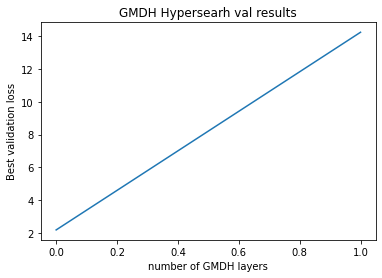

In [5]:
plt.title('GMDH Hypersearh val results')
plt.plot(all_metrics)
plt.xlabel('number of GMDH layers')
plt.ylabel('Best validation loss')
plt.show()

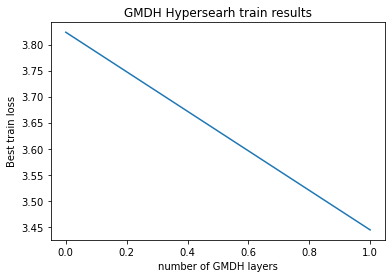

In [6]:
plt.title('GMDH Hypersearh train results')
plt.plot(all_train_metrics)
plt.xlabel('number of GMDH layers')
plt.ylabel('Best train loss')
plt.show()

In [7]:
prediction = best_test_pred
prediction_train = best_train_pred

print(f"Test MSE: {MSE(y_test, prediction)[0]}")
print(f"Train MSE: {MSE(y_train, prediction_train)[0]}")

Test MSE: 2.191677026578003
Train MSE: 3.8235822692053794


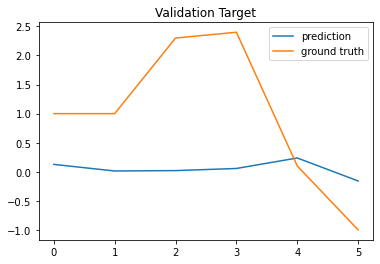

In [8]:
plt.title('Validation Target')
plt.plot(prediction, label='prediction')
plt.plot(y_test, label='ground truth')
plt.legend()
plt.show()

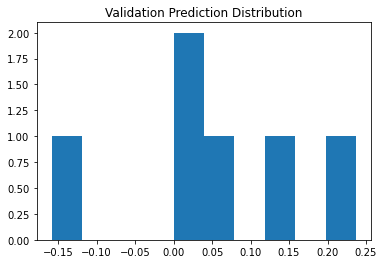

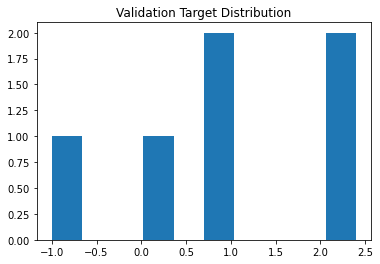

In [9]:
plt.title('Validation Prediction Distribution')
plt.hist(prediction)
plt.show()

plt.title('Validation Target Distribution')
plt.hist(y_test)
plt.show()